# Import Libraries

In [1]:
import torch
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch import optim
import os
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Need to include RNN architecture from intents_classification.ipynb in order to load the model

In [2]:
class RNN(nn.Module):
    name = "RNN" # for keeping track of model type
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input, hidden):
        # Check that input size matches expected size
        if input.size(1) != self.i2o.in_features - self.hidden_size:
            raise ValueError("Input size mismatch: expected {}, got {}".format(
                self.i2o.in_features - self.hidden_size, input.size(1)
            ))
        combined = torch.cat((input, hidden), 1)
        # Ensure combined size matches linear layer input
        if combined.size(1) != self.i2o.in_features:
            raise RuntimeError("Concatenated size mismatch: expected {}, got {}".format(
                self.i2o.in_features, combined.size(1)
            ))
        hidden = self.i2o(combined)
        hidden = self.ReLU(hidden)
        hidden = self.dropout(hidden)
        output = self.softmax(hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size).to(device)

In [3]:
base_path = os.getcwd()
clean_data_path = os.path.join(base_path, '../clean_data')
intent_class_path = os.path.join(clean_data_path, 'models/intents_classifier.pth')
entity_class_path = os.path.join(clean_data_path, 'models/ner_model')
intent_model = torch.load(intent_class_path)
entity_model = spacy.load(entity_class_path)

In [4]:
def bag_of_words(sentence, words, lemmatizer):
    if sentence is None:
        return np.zeros(len(words))
    sentence_words = nltk.tokenize.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    bag = [0] * len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                bag[i] = 1
    return np.array(bag)

In [5]:
import json
def load_data(path):
    # Load intents
    with open(path, 'r') as file:
        intents = json.load(file)['intents']

    intents_dict = {}
    response_dict = {}
    for intent in intents:
        intents_dict[intent['tag']] = intent['patterns']
        response_dict[intent['tag']] = intent['responses']

    return intents_dict, response_dict

In [6]:
def process_intents(intents_dict):
    lemmatizer = WordNetLemmatizer()

    words = []
    intents = []
    words_tokenized = []
    ignore = ['?', '!', '.', ',']

    for intent in intents_dict:
        for pattern in intents_dict[intent]:
            w = nltk.tokenize.word_tokenize(pattern)
            words.extend(w) # append words from tokenized pattern to 'words'
            words_tokenized.append((w, intent)) # list of tuples containing list of words and intent class
            if intent not in intents:
                intents.append(intent) # unique list of intents

    # find base form of word and remove ignore words
    words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore]
    words = sorted(list(set(words))) # remove duplicates and sort

    intents = sorted(intents)

    return words, intents, words_tokenized

In [7]:
intents_dict, response_dict = load_data('../clean_data/intents_enriched.json')
n_categories = len(intents_dict)
print(n_categories)

15


In [8]:
words, intents, words_tokenized = process_intents(intents_dict)

In [9]:
def predict(model, input_line, words, n_predictions=3):
    # Just return an output given a line
    def evaluate(line_tensor):
        hidden = model.initHidden(line_tensor.size(0))
        output, hidden = model(line_tensor, hidden)

        return output
    
    def words_in_bag(sentence):
        lemmatizer = WordNetLemmatizer()
        if sentence is None:
            return np.zeros(len(words))
        sentence_words = nltk.tokenize.word_tokenize(sentence)
        sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
        bag = [0] * len(words)
        for s in sentence_words:
            for i, w in enumerate(words):
                if w == s:
                    bag[i] = 1
        return np.array(bag)
    
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(torch.from_numpy(words_in_bag(input_line)).view(1, -1))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, intents[category_index]))
            predictions.append([value, intents[category_index]])

    return predictions

In [10]:
def get_intents_and_entities(intent_model, entity_model, text, words):
    intent_prob = -np.inf
    intents_pred = predict(intent_model, text, words)
    intent = ''

    for item in intents_pred:
        if item[0] > intent_prob:
            intent_prob = item[0]
            intent = item[1]
    ner_doc = entity_model(text)
    entities = [(ent.text, ent.label_) for ent in ner_doc.ents]
    return intent, entities

In [11]:
text = "The patient was prescribed 500 mg of Metformin."
intent, entities = get_intents_and_entities(intent_model, entity_model, text, words)
print(intent)
print(entities)


> The patient was prescribed 500 mg of Metformin.
(-0.84) symptom_check
(-2.13) prescribe_medication
(-2.34) search_blood_pressure_by_patient_id
symptom_check
[('500 mg', 'DOSAGE'), ('Metformin', 'MEDICATION')]


In [12]:
INTENT_PREFIX = "[INTENT]"
ENTITY_PREFIX = "[ENTITY]"

In [13]:
def augment_input_with_intent_and_entities(user_input, intent, entities):
    # Augment the input with the intent
    augmented_input = f"{INTENT_PREFIX}{intent} " + user_input
    
    # Augment the input with entities
    for entity, entity_type in entities:
        augmented_input += f" {ENTITY_PREFIX}{entity_type}" # does it need to know just the type or the entity itself as well?
    
    return augmented_input

In [16]:
!pip install transformers -U
!pip install accelerate -U

In [14]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [15]:
# Example text to tokenize
text = "What is the capital of France?"


pad_token_id = tokenizer.pad_token_id  # Usually None for GPT-2
if pad_token_id is None:
    # If no pad token ID, use a commonly unused ID (like 0)
    pad_token_id = 0

# Update the tokenizer's pad token
tokenizer.pad_token = "<pad>"
tokenizer.pad_token_id = pad_token_id

# Tokenize the text and create an attention mask
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

# Extract input IDs and attention mask
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Ensure attention mask is passed to the model
output = model.generate(input_ids, attention_mask=attention_mask, pad_token_id=pad_token_id, max_length=30, num_return_sequences=1)

# Decode the output to get the response text
response = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated Response:", response)

Generated Response: What is the capital of France?

The capital of France is Paris.

The capital of France is Paris.

The capital of


In [16]:
def prepare_data(intents_dict, response_dict, intent_model, entity_model, augment_data=False):
    training_text = ""
    testing_text = ""
    input_for_bleu = [] # list of input texts for BLEU score calculation
    output_for_bleu = []
    if not augment_data:
        for intent in intents_dict:
            for index, pattern in enumerate(intents_dict[intent]):
                if random.random() < 0.2:
                    testing_text += f"Q: {pattern} A: {response_dict[intent][index]}\n"
                    input_for_bleu.append(pattern)
                    output_for_bleu.append(response_dict[intent][index])
                else:
                    training_text += f"Q: {pattern} A: {response_dict[intent][index]}\n"

    else:
        for intent in intents_dict:
            for index, pattern in enumerate(intents_dict[intent]):
                intent_pred, entities_pred = get_intents_and_entities(intent_model, entity_model, pattern, words)
                augmented_input = augment_input_with_intent_and_entities(pattern, intent_pred, entities_pred)
                if random.random() < 0.2:
                    testing_text += f"Q: {augmented_input} A: {response_dict[intent][index]}\n"
                    input_for_bleu.append(augmented_input)
                    output_for_bleu.append(response_dict[intent][index])
                else:
                    training_text += f"Q: {augmented_input} A: {response_dict[intent][index]}\n"
            

    print("Train text:", training_text[:1000])
    print("Test text:", testing_text[:1000])

    with open("training_text.txt", "w") as file:
        file.write(training_text)
    
    return input_for_bleu, output_for_bleu, training_text, testing_text

In [17]:
input_for_bleu, output_for_bleu, training_text, testing_text = prepare_data(intents_dict, response_dict, intent_model, entity_model, augment_data=False)
print(len(training_text), len(testing_text))

Train text: Q: Hello, how are you? A: Well hello. I'm doing well, thank you. How may I help you today?
Q: Hello, how are you doing? A: Well hello. I'm doing well, thanks for asking. How may I help you today?
Q: Hello, how's it going? A: Well hello. It's going well, thank you. How may I help you today?
Q: Hello, how do you do? A: Well hello. I'm doing well, thank you. How may I help you today?
Q: Hello, How's it hangin? A: Well hello. It's hangin'. How may I help you today?
Q: Hello, what's going on? A: Well hello. Not much thanks for asking. How may I help you today?
Q: Hello A: Well hello.  How may I help you today?
Q: Hi, how are you? A: Hi there. I'm doing well, thank you. How may I help you today?
Q: Hi, how are you doing? A: Hi there. I'm doing well, thanks for asking. How may I help you today?
Q: Hi, how's it going? A: Hi there. It's going well, thank you. How may I help you today?
Q: Hi, what's up? A: Hi there. Not much, thanks for asking. How may I help you today?
Q: Hi, how do

In [18]:
print(len(input_for_bleu), len(output_for_bleu))

1284 1284


In [19]:
from transformers import TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

def train_model(model, path):
    model = model.to(device)

    dataset = TextDataset(
        tokenizer=tokenizer,
        file_path="training_text.txt",
        block_size=128,
    )

    # Data collator for language modeling (applies random masking for training)
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False  # Set mlm=False for GPT-2 fine-tuning
    )

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        overwrite_output_dir=True,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        save_steps=500,
        save_total_limit=2,
        prediction_loss_only=True,  # Focus on language modeling loss
    )

    # Create a Trainer for fine-tuning
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        data_collator=data_collator,
    )

    # Fine-tune the GPT-2 model
    trainer.train()

    # Save the fine-tuned model
    trainer.save_model(path)

In [20]:
train_model(model, "../clean_data/models/fine_tuned_gpt2")

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\data\datasets\language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
100%|██████████| 321/321 [24:41<00:00,  4.62s/it]


{'train_runtime': 1481.4778, 'train_samples_per_second': 1.723, 'train_steps_per_second': 0.217, 'train_loss': 0.42654770705558803, 'epoch': 3.0}


In [21]:
# Load the fine-tuned model
fine_tuned_model = GPT2LMHeadModel.from_pretrained("../clean_data/models/fine_tuned_gpt2")

In [22]:
def generate_response(text, model, tokenizer):
    pad_token_id = tokenizer.pad_token_id  # Usually None for GPT-2
    if pad_token_id is None:
        # If no pad token ID, use a commonly unused ID (like 0)
        pad_token_id = 0

    # Update the tokenizer's pad token
    tokenizer.pad_token = "<pad>"
    tokenizer.pad_token_id = pad_token_id

    # Tokenize the text and create an attention mask
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Extract input IDs and attention mask
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Ensure attention mask is passed to the model
    output = model.generate(input_ids, attention_mask=attention_mask, pad_token_id=pad_token_id, max_length=30, num_return_sequences=1)

    # Decode the output to get the response text
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    if "Q:" in response:
        if "A:" in response.split("Q: ")[0]:
            return response.split("Q: ")[0].split("A: ")[1]
        else:
            return response.split("Q: ")[0]

    return response

In [26]:
response = generate_response("Kill", fine_tuned_model, tokenizer)
print(response)

Kill_blood_pressure_search I want to load blood pressure data for patient by name and ID [ENTITY]SYMPTOM A:


In [36]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

model_responses = []
for input_text in input_for_bleu:
    response = generate_response(input_text, fine_tuned_model, tokenizer)
    model_responses.append(response)

# Tokenize the text
references = [nltk.word_tokenize(ans.lower()) for ans in output_for_bleu]
candidates = [nltk.word_tokenize(resp.lower()) for resp in model_responses]

print("data retrieved")

# Calculate BLEU scores
bleu_scores = [sentence_bleu(ref, cand, smoothing_function=SmoothingFunction().method4) for ref, cand in zip(references, candidates)]

# Print BLEU scores for each response
for i, score in enumerate(bleu_scores):
    print(f"BLEU score for response {i+1}: {score:.4f}")

data retrieved
BLEU score for response 1: 0.0235
BLEU score for response 2: 0.0211
BLEU score for response 3: 0.0184
BLEU score for response 4: 0.0184
BLEU score for response 5: 0.0211
BLEU score for response 6: 0.0249
BLEU score for response 7: 0.0184
BLEU score for response 8: 0.0143
BLEU score for response 9: 0.0235
BLEU score for response 10: 0.0143
BLEU score for response 11: 0.0143
BLEU score for response 12: 0.0179
BLEU score for response 13: 0.0143
BLEU score for response 14: 0.0192
BLEU score for response 15: 0.0000
BLEU score for response 16: 0.0000
BLEU score for response 17: 0.0000
BLEU score for response 18: 0.0000
BLEU score for response 19: 0.0000
BLEU score for response 20: 0.0000
BLEU score for response 21: 0.0000
BLEU score for response 22: 0.0000
BLEU score for response 23: 0.0000
BLEU score for response 24: 0.0000
BLEU score for response 25: 0.0000
BLEU score for response 26: 0.0000
BLEU score for response 27: 0.0000
BLEU score for response 28: 0.0000
BLEU score for

In [37]:
print("Average BLEU score:", sum(bleu_scores) / len(bleu_scores))

Average BLEU score: 0.0017313807699900646


In [38]:
print("Max BLEU score:", max(bleu_scores))

Max BLEU score: 0.02573285025273419


In [39]:
len(references), len(candidates)

(866, 866)

In [59]:
# show where reference and candidate are different
for i, (ref, cand) in enumerate(zip(references, candidates)):
    if ref != cand:
        print(f"Reference: {ref}")
        print(f"Candidate: {cand}")
        print()
        break

Reference: ['well', 'hello', '.', 'i', "'m", 'doing', 'well', ',', 'thank', 'you', '.', 'how', 'may', 'i', 'help', 'you', 'today', '?']
Candidate: ['i', "'m", 'doing', 'well', ',', 'thank', 'you', '.', 'how', 'may', 'i', 'help', 'you', 'today', '?']



In [41]:
!pip install rouge

In [53]:
from rouge import Rouge
rouge = Rouge()

# join the tokens back into a sentence
rouge_refs = [' '.join(ref) for ref in references]
rouge_cands = [' '.join(cand) for cand in candidates]

# Calculate rouge scores
rouge_scores = [rouge.get_scores(ref, cand) for ref, cand in zip(rouge_refs, rouge_cands)]

In [56]:
print(rouge_scores[0])

[{'rouge-1': {'r': 1.0, 'p': 0.9230769230769231, 'f': 0.959999995008}, 'rouge-2': {'r': 1.0, 'p': 0.8666666666666667, 'f': 0.9285714235969389}, 'rouge-l': {'r': 1.0, 'p': 0.9230769230769231, 'f': 0.959999995008}}]


In [58]:
# calculate average rouge scores
rouge_1_f1 = sum([score[0]['rouge-1']['f'] for score in rouge_scores]) / len(rouge_scores)
rouge_2_f1 = sum([score[0]['rouge-2']['f'] for score in rouge_scores]) / len(rouge_scores)
rouge_l_f1 = sum([score[0]['rouge-l']['f'] for score in rouge_scores]) / len(rouge_scores)
rouge_1_recall = sum([score[0]['rouge-1']['r'] for score in rouge_scores]) / len(rouge_scores)
rouge_2_recall = sum([score[0]['rouge-2']['r'] for score in rouge_scores]) / len(rouge_scores)
rouge_l_recall = sum([score[0]['rouge-l']['r'] for score in rouge_scores]) / len(rouge_scores)
rouge_1_precision = sum([score[0]['rouge-1']['p'] for score in rouge_scores]) / len(rouge_scores)
rouge_2_precision = sum([score[0]['rouge-2']['p'] for score in rouge_scores]) / len(rouge_scores)
rouge_l_precision = sum([score[0]['rouge-l']['p'] for score in rouge_scores]) / len(rouge_scores)
print("Average ROUGE-1 F1:", rouge_1_f1)
print("Average ROUGE-2 F1:", rouge_2_f1)
print("Average ROUGE-L F1:", rouge_l_f1)
print("Average ROUGE-1 Recall:", rouge_1_recall)
print("Average ROUGE-2 Recall:", rouge_2_recall)
print("Average ROUGE-L Recall:", rouge_l_recall)
print("Average ROUGE-1 Precision:", rouge_1_precision)
print("Average ROUGE-2 Precision:", rouge_2_precision)
print("Average ROUGE-L Precision:", rouge_l_precision)

Average ROUGE-1 F1: 0.8826965367710825
Average ROUGE-2 F1: 0.768655670439749
Average ROUGE-L F1: 0.8825425721829379
Average ROUGE-1 Recall: 0.9045756559056829
Average ROUGE-2 Recall: 0.8033435518708912
Average ROUGE-L Recall: 0.9044424173197885
Average ROUGE-1 Precision: 0.8717240954202958
Average ROUGE-2 Precision: 0.7566590696285603
Average ROUGE-L Precision: 0.871541768934335


In [66]:
# Example usage
user_input = "How much Metformin should I take?"
intent = "dosage_query"
entities = [('500 mg', 'DOSAGE'), ('Metformin', 'MEDICATION')]

augmented_input = augment_input_with_intent_and_entities(user_input, intent, entities)

In [67]:
augmented_input

'[INTENT]dosage_query How much Metformin should I take? [ENTITY]DOSAGE [ENTITY]MEDICATION'

In [70]:
input_for_bleu, output_for_bleu, training_text, testing_text = prepare_data(intents_dict, response_dict, intent_model, entity_model, augment_data=True)
print(len(training_text), len(testing_text))


> Hello, how are you?
(-0.17) greeting
(-3.03) options
(-3.44) thanks

> Hello, how are you doing?
(-0.12) greeting
(-3.47) options
(-3.80) thanks

> Hello, how's it going?
(-0.04) greeting
(-5.24) search_hospital_by_params
(-5.34) adverse_drug

> Hello, what's up?
(-0.27) greeting
(-3.05) options
(-3.61) search_hospital_by_params

> Hello, how do you do?
(-0.27) greeting
(-2.75) options
(-2.89) thanks

> Hello, How's it hangin?
(-0.06) greeting
(-4.86) search_hospital_by_params
(-4.96) adverse_drug

> Hello, what's going on?
(-0.14) greeting
(-3.59) options
(-4.12) thanks

> Hello
(-1.74) greeting
(-1.95) search_hospital_by_params
(-2.13) search_pharmacy_by_name

> Hi, how are you?
(-0.19) greeting
(-2.98) options
(-3.27) thanks

> Hi, how are you doing?
(-0.13) greeting
(-3.42) options
(-3.62) thanks

> Hi, how's it going?
(-0.05) greeting
(-5.10) search_hospital_by_params
(-5.22) adverse_drug

> Hi, what's up?
(-0.29) greeting
(-3.02) options
(-3.48) thanks

> Hi, how do you do?
(-

In [71]:
# Load the GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [74]:
train_model(model)

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\data\datasets\language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
100%|██████████| 321/321 [22:26<00:00,  4.19s/it]


{'train_runtime': 1346.0829, 'train_samples_per_second': 1.897, 'train_steps_per_second': 0.238, 'train_loss': 0.4281348112587617, 'epoch': 3.0}


In [75]:
augmented_model = GPT2LMHeadModel.from_pretrained("../clean_data/models/fine_tuned_gpt2_augmented")

In [78]:
def augment_and_generate(user_input, intent_model, entity_model, augmented_model, tokenizer, words):
    intent, entities = get_intents_and_entities(intent_model, entity_model, user_input, words)
    augmented_input = augment_input_with_intent_and_entities(user_input, intent, entities)
    response = generate_response(augmented_input, augmented_model, tokenizer)
    return response

In [79]:
user_input = "How much Metformin should I take?"
response = augment_and_generate(user_input, intent_model, entity_model, augmented_model, tokenizer, words)
print(response)


> How much Metformin should I take?
(-1.21) greeting
(-2.18) search_pharmacy_by_name
(-2.40) thanks
[INTENT]greeting How much Metformin should I take? A: I can take it for a day or two. How may


----

seq2seq

In [168]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [169]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        self.relu = nn.ReLU()

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        if target_tensor is not None:
            sequence_length = target_tensor.size(1)  # Use the length of the target tensor
        else:
            sequence_length = 10 # Arbitrary value

        for i in range(sequence_length):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = self.softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = self.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [170]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = self.softmax(scores)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        if target_tensor is not None:
            sequence_length = target_tensor.size(1)  # Use the length of the target tensor
        else:
            sequence_length = 10 # Arbitrary value

        for i in range(sequence_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = self.softmax(decoder_outputs)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [171]:
SOS_token = 0
EOS_token = 1
lemmatizer = WordNetLemmatizer()

class Corpus:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [172]:
import string
def normalize_string(s):
    lemmatizer = WordNetLemmatizer()
    # Tokenize the sentence. This also implicitly removes punctuation if we do not consider them as separate tokens.
    tokens = word_tokenize(s)
    # Lemmatize and lowercase each word, excluding punctuation
    lemmatized_tokens = [lemmatizer.lemmatize(token).lower() for token in tokens if token not in string.punctuation]
    # Reconstruct the sentence from lemmatized tokens
    lemmatized_sentence = ' '.join(lemmatized_tokens)

    return lemmatized_sentence

In [173]:
import json

def load_data(path):
    # Load intents
    with open(path, 'r') as file:
        intents = json.load(file)['intents']

    intents_dict = {}
    response_dict = {}
    for intent in intents:
        intents_dict[intent['tag']] = intent['patterns']
        response_dict[intent['tag']] = intent['responses']

    return intents_dict, response_dict

In [174]:
intents, responses = load_data(os.path.join(clean_data_path, 'intents_enriched.json'))
for k in intents:
    if len(intents[k]) != len(responses[k]):
        print(k)

In [175]:
def makePairs():
    print("Reading lines...")
    
    questions, responses = load_data('../clean_data/intents_enriched.json')

    # make pairs of input and response and normalize
    pairs = []
    for tag in responses:
        for i in range(len(responses[tag])):
            _, entities = get_intents_and_entities(questions[tag][i], intent_model, entity_model)
            augmented_input = augment_input_with_intent_and_entities(normalize_string(questions[tag][i]), tag, entities)
            pairs.append([augmented_input, responses[tag][i]])
        
    inputs = Corpus('inputs')
    outputs = Corpus('responses')

    return inputs, outputs, pairs

In [176]:
def prepareData():
    input, output, pairs = makePairs()
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input.addSentence(pair[0])
        output.addSentence(pair[1])
    print("Counted words:")
    print(input.name, input.n_words)
    print(output.name, output.n_words)
    return input, output, pairs

In [177]:
def find_max_len(pairs):
    max_length = 0
    for pair in pairs:
        if len(pair[0].split(' ')) > max_length:
            max_length = len(pair[0].split(' '))
        if len(pair[1].split(' ')) > max_length:
            max_length = len(pair[1].split(' '))

    max_length += 1

    return max_length

In [178]:
def indexesFromSentence(obj, sentence):
    return [obj.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(obj, sentence):
    indexes = indexesFromSentence(obj, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def get_dataloader(batch_size, new_data=False):
    if not new_data:
        with open(os.path.join(clean_data_path, 'input_corpus.pkl'), 'rb') as f:
            inputs = pickle.load(f)

        with open(os.path.join(clean_data_path, 'output_corpus.pkl'), 'rb') as f:
            outputs = pickle.load(f)

        with open(os.path.join(clean_data_path, 'pairs.pkl'), 'rb') as f:
            pairs = pickle.load(f)
    
    else:
        inputs, outputs, pairs = prepareData()
        with open(os.path.join(clean_data_path, 'input_corpus.pkl'), 'wb') as f:
            pickle.dump(inputs, f)

        with open(os.path.join(clean_data_path, 'output_corpus.pkl'), 'wb') as f:
            pickle.dump(outputs, f)

        with open(os.path.join(clean_data_path, 'pairs.pkl'), 'wb') as f:
            pickle.dump(pairs, f)

    max_length = find_max_len(pairs)

    n = len(pairs)
    input_ids = np.zeros((n, max_length), dtype=np.int32)
    target_ids = np.zeros((n, max_length), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(inputs, inp)
        tgt_ids = indexesFromSentence(outputs, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return inputs, outputs, train_dataloader

In [179]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [180]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [181]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [182]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Reading lines...


Read 4129 sentence pairs
Counting words...
Counted words:
inputs 467
responses 98
0m 34s (- 8m 32s) (5 6%) 0.1710
1m 8s (- 8m 0s) (10 12%) 0.0091
1m 42s (- 7m 22s) (15 18%) 0.0051
2m 16s (- 6m 48s) (20 25%) 0.0041
2m 49s (- 6m 13s) (25 31%) 0.0029
3m 23s (- 5m 39s) (30 37%) 0.0017
3m 57s (- 5m 5s) (35 43%) 0.0015
4m 31s (- 4m 31s) (40 50%) 0.0009
5m 4s (- 3m 57s) (45 56%) 0.0006
5m 39s (- 3m 23s) (50 62%) 0.0006
6m 13s (- 2m 49s) (55 68%) 0.0003
6m 46s (- 2m 15s) (60 75%) 0.0001
7m 20s (- 1m 41s) (65 81%) 0.0001
7m 54s (- 1m 7s) (70 87%) 0.0005
8m 27s (- 0m 33s) (75 93%) 0.0002
9m 1s (- 0m 0s) (80 100%) 0.0000


<Figure size 640x480 with 0 Axes>

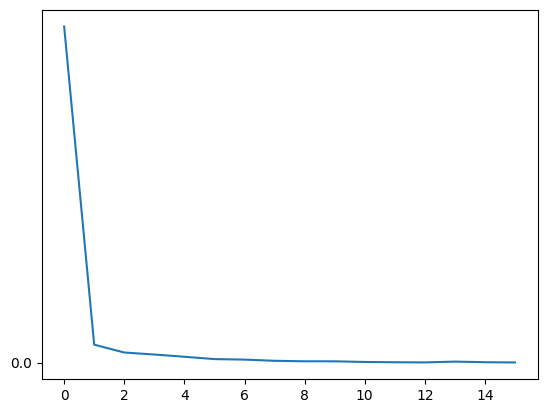

In [185]:
hidden_size = 128
batch_size = 32

inputs, outputs, train_dataloader = get_dataloader(batch_size, new_data=True)

encoder = EncoderRNN(inputs.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, outputs.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [203]:
with open(os.path.join(clean_data_path, 'input_corpus.pkl'), 'rb') as f:
    inputs = pickle.load(f)

with open(os.path.join(clean_data_path, 'output_corpus.pkl'), 'rb') as f:
    outputs = pickle.load(f)

with open(os.path.join(clean_data_path, 'pairs.pkl'), 'rb') as f:
    pairs = pickle.load(f)

ModuleNotFoundError: No module named 'helpers'

In [196]:
def evaluate(encoder, decoder, sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(inputs, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                break
            decoded_words.append(outputs.index2word[idx.item()])
    return decoded_words, decoder_attn

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

def evaluateRandomly(encoder, decoder, n=10):
    references = []
    hypotheses = []
            
    for i in range(n):
        pair = random.choice(pairs)
        print('Input:', pair[0])
        print('Target:', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        
        # Store the reference sentence and the hypothesis for BLEU calculation
        references.append([pair[1].split()])
        hypotheses.append(output_words)
        
        print('Output:', output_sentence)
        print('')

    # Calculate BLEU score
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=SmoothingFunction().method4)
    print(f"Corpus BLEU score: {bleu_score:.2f}")

In [194]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

Input: [INTENT]thanks thank you for that
Target: You're very welcome. Is there anything else I can assist you with today?
Output: You're very welcome. Is there anything else I can assist

Input: [INTENT]search_hospital_by_type find me a child hospital near me [ENTITY]DIAGNOSIS
Target: Loading hospital details
Output: Loading hospital details

Input: [INTENT]blood_pressure_search i want to pull up blood pressure history for patient by id [ENTITY]MEDICATION [ENTITY]MEDICATION
Target: Please provide patient ID
Output: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

Input: [INTENT]thanks thank you you 're a treasure [ENTITY]BODY_PART
Target: You're very welcome. Is there anything else I can assist you with today?
Output: You're very welcome. Is there anything else I can assist

Input: [INTENT]pharmacy_search show pharmacy near my location [ENTITY]BODY_PART
Target: Please provide pharmacy name
Output: Please provide pharmacy name

Input: [INTENT]pharmacy_search navigate to nearyby drugstore [ENTIT

In [201]:
def process_input(text):
    intent, entities = get_intents_and_entities(text, intent_model, entity_model)
    augmented_input = augment_input_with_intent_and_entities(normalize_string(text), intent, entities)
    return augmented_input

input = [INTENT]greeting hello how are you
output = Well hello. I'm doing well, thank you.


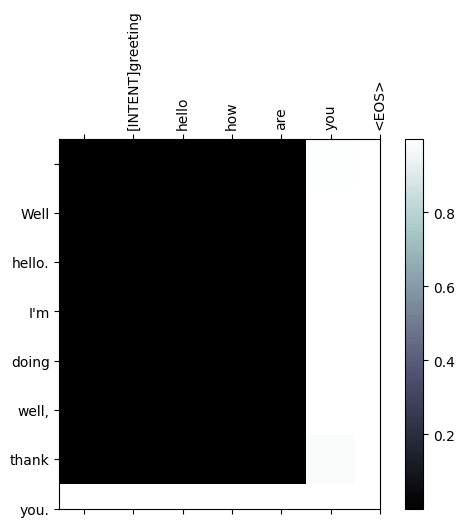

input = [INTENT]goodbye bye have a good day
output = Goodbye! Please come again!


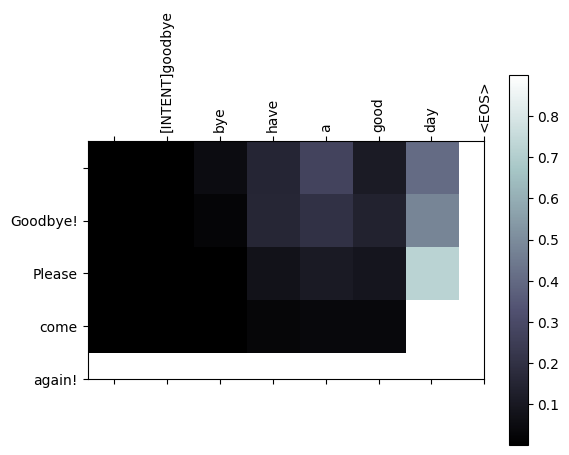

input = [INTENT]thanks what can you do for me
output = SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS


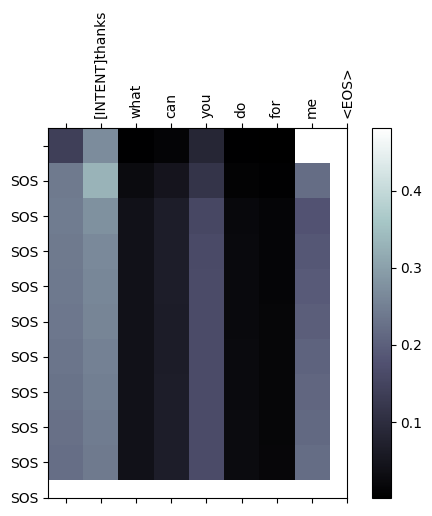

input = [INTENT]search_hospital_by_params find me a hospital nearby
output = Loading hospital details


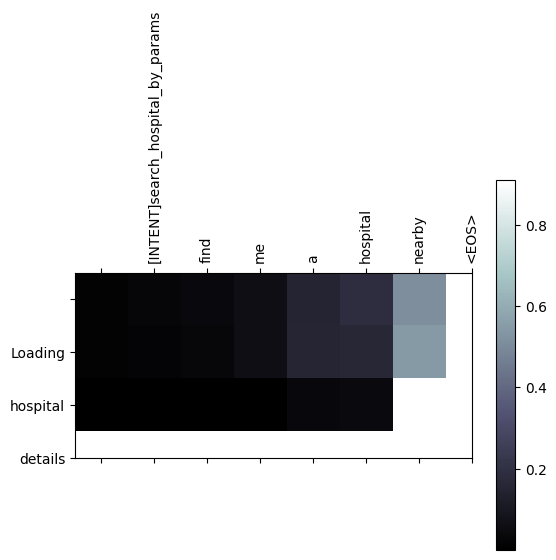

In [202]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(input_sentence.split(' ')) + 2))
    ax.set_yticks(np.arange(len(output_words) + 1))

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention(process_input('Hello. How are you?'))

evaluateAndShowAttention(process_input('Bye. Have a good day.'))

evaluateAndShowAttention(process_input('What can you do for me?'))

evaluateAndShowAttention(process_input('Find me a hospital nearby.'))

-----